# Capstone Phase 2 - SVM  
Previous phase 2 notebook was getting a bit long, so modeling is continued here.

### Import some libraries we'll need

In [1]:
import joblib
import pandas as pd
import numpy as np
from sklearn import preprocessing
from zipfile import ZipFile

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import plot_confusion_matrix

In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

### Some utility stuff

In [4]:
def transform_data(df):
    no_labels = df.drop(['label', 'attack_cat'], axis=1)
    one_hot = pd.get_dummies(no_labels, columns=['proto', 'service', 'state'], prefix=['proto', 'service', 'state'])
    scaler = preprocessing.StandardScaler().fit(one_hot)
    standardized = scaler.transform(one_hot)
    std = pd.DataFrame(standardized, columns=one_hot.columns)

    labels = df['label'].copy()
    cats = df['attack_cat'].copy()
    
    return std, labels, cats

In [5]:
def plt_norm_confmat(model, X, y, title, fname=None, labels=None):
    fig, ax = plt.subplots(figsize=(7, 7))
    display = plot_confusion_matrix(model, X, y, display_labels=labels, cmap=plt.cm.Blues, 
                                    normalize='true', xticks_rotation='vertical', ax=ax)
    display.ax_.set_title(title)
    if fname is not None:
        file = './images/' + fname + '.png'
        plt.savefig(file, dpi=300, bbox_inches='tight')

In [6]:
def gen_metrics(y_train, y_pred):
    conf_mat = confusion_matrix(y_train, y_pred)
    class_rep = classification_report(y_train, y_pred, zero_division=0)
    rep_dict = classification_report(y_train, y_pred, zero_division=0, output_dict=True)
    acc = accuracy_score(y_train, y_pred)
    return conf_mat, class_rep, rep_dict, acc

### Load data and apply transformations identified during exploration phase

In [7]:
with ZipFile('./Data/UNSW_NB15 training and testing sets.zip') as datasets_zip:
    # open each file and read in to a DataFrame
    with datasets_zip.open('UNSW_NB15_training-set.csv') as training_file:
        training_data = pd.read_csv(training_file, index_col='id')
    with datasets_zip.open('UNSW_NB15_testing-set.csv') as testing_file:
        testing_data = pd.read_csv(testing_file, index_col='id')

In [8]:
training_data_std, training_labels, training_cats = transform_data(training_data)
testing_data_std, testing_labels, testing_cats = transform_data(testing_data)

In [9]:
label_encoder = preprocessing.LabelEncoder()
y_train = label_encoder.fit_transform(training_cats)
y_test = label_encoder.fit_transform(testing_cats)

In [10]:
class_names = list(label_encoder.classes_)

### Load feature subsets

In [11]:
feature_subsets = joblib.load('./data/feature_subsets.pkl')

In [12]:
train_std_ig = training_data_std[feature_subsets['ig']].copy()
test_std_ig = testing_data_std[feature_subsets['ig']].copy()

train_std_anova = training_data_std[feature_subsets['anova']].copy()
test_std_anova = testing_data_std[feature_subsets['anova']].copy()

train_std_vt = training_data_std[feature_subsets['vt']].copy()
test_std_vt = testing_data_std[feature_subsets['vt']].copy()

train_std_mad = training_data_std[feature_subsets['mad']].copy()
test_std_mad = testing_data_std[feature_subsets['mad']].copy()

train_std_corr = training_data_std[feature_subsets['corr']].copy()
test_std_corr = testing_data_std[feature_subsets['corr']].copy()

train_std_rfe = training_data_std[feature_subsets['rfe']].copy()
test_std_rfe = testing_data_std[feature_subsets['rfe']].copy()

## Support Vector Machine (SVM)

In [13]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

#### Train model with best params

In [53]:
lin_svc_model = LinearSVC(C=10, loss='squared_hinge', max_iter=15000, dual=False, class_weight='balanced')

In [27]:
lin_svc_model.fit(train_std_ig, y_train)

LinearSVC(C=10, class_weight='balanced', dual=False, max_iter=15000)

In [28]:
joblib.dump(lin_svc_model, './data/lin_svc_model.pkl')
#lin_svc_model = joblib.load('./data/lin_svc_model.pkl')

['./data/lin_svc_model.pkl']

In [30]:
lin_svc_model.n_iter_

479

In [31]:
lin_svc_model.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [32]:
lin_svc_model.intercept_

array([-10.91355356,  -1.68611054,  -1.24353067,  -1.32824417,
        -2.95267042,  -1.90020613,  -0.24170739,  -2.55131467,
       -26.07826765,  -3.34235224])

In [29]:
lin_svc_model.coef_

array([[ 6.84623650e-01, -1.88848684e-01,  3.77899361e-02,
        -4.66494307e+00, -9.56399694e-03,  2.80981105e-01,
         1.28033421e-02,  3.72961499e-01,  5.76856654e-02,
        -1.43714818e-02, -4.66120146e-02, -4.03052196e-01,
        -3.34943102e+01,  2.70661475e-01,  6.37049252e-02,
        -3.14497596e-01, -5.10755188e-01, -3.63650190e+00,
        -1.75069145e-01, -6.06454217e-01],
       [ 2.92982208e-01, -1.22884400e-01,  6.49340063e-03,
         1.43324150e+00, -2.06601565e-02,  2.10688629e-02,
         2.76082410e-02,  1.49161851e+00, -1.38167289e-01,
        -3.47621255e-02, -1.21842772e-01, -2.11992845e-01,
        -1.47011119e+00,  2.07166590e-01, -2.42751728e-01,
         1.37893926e-01, -2.17007242e+00, -1.65706888e+00,
        -1.02653408e-01, -3.18796893e-01],
       [ 1.17443769e-02, -1.11334364e-02, -3.26963168e-02,
         2.72400460e-02,  3.42493029e-02,  1.93082567e-02,
         3.12486214e-03,  6.31822869e-01, -2.14692328e-01,
         6.03950529e-02, -1.2

In [33]:
lin_svc_model.get_params()

{'C': 10,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 15000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

In [34]:
lin_svc_model.score(train_std_ig, y_train)

0.6670088570271642

#### Grid Search

In [43]:
params = {'C':[1, 10, 100, 1000]}
lin_svc_gs = GridSearchCV(LinearSVC(loss='squared_hinge', max_iter=15000, dual=False, class_weight='balanced'), 
                          params, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)

In [38]:
lin_svc_gs_results = lin_svc_gs.fit(train_std_ig, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [39]:
print(lin_svc_gs_results.best_score_)
print(lin_svc_gs_results.best_estimator_)
print(lin_svc_gs_results.best_params_)

0.661043338409157
LinearSVC(C=1, class_weight='balanced', dual=False, max_iter=15000)
{'C': 1}


In [50]:
results = lin_svc_gs_results.cv_results_
results_df = pd.DataFrame(results)
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,71.834128,2.399748,0.024434,0.002916,1,{'C': 1},0.707000,0.739559,0.536572,0.661043,0.089013,1
1,112.686165,22.785331,0.027068,0.003437,10,{'C': 10},0.706914,0.739730,0.535699,0.660781,0.089455,2
2,154.250551,38.837478,0.021068,0.001913,100,{'C': 100},0.706384,0.739576,0.534399,0.660119,0.089925,4
3,170.510487,46.034541,0.023552,0.003599,1000,{'C': 1000},0.706503,0.740141,0.534313,0.660319,0.090152,3


In [44]:
joblib.dump(lin_svc_gs, './data/lin_svc_gs.pkl')
#lin_svc_gs = joblib.load('./data/lin_svc_gs.pkl')
joblib.dump(lin_svc_gs_results, './data/lin_svc_gs_results.pkl')
#lin_svc_gs_results = joblib.load('./data/lin_svc_gs_results.pkl')

['./data/lin_svc_gs_results.pkl']

In [45]:
params = {'C':[2, 4, 8, 16]}
lin_svc_gs_2 = GridSearchCV(LinearSVC(loss='squared_hinge', dual=False, class_weight='balanced'), 
                          params, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

In [46]:
lin_svc_gs_results_2 = lin_svc_gs_2.fit(train_std_ig, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [47]:
print(lin_svc_gs_results_2.best_score_)
print(lin_svc_gs_results_2.best_estimator_)
print(lin_svc_gs_results_2.best_params_)

0.6633471428776387
LinearSVC(C=2, class_weight='balanced', dual=False)
{'C': 2}


In [49]:
results_2 = lin_svc_gs_results_2.cv_results_
results_df_2 = pd.DataFrame(results_2)
results_df_2

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,112.202564,21.304347,0.016685,0.004541,2,{'C': 2},0.711968,0.724877,0.751255,0.622191,0.506445,0.663347,0.089655,1
1,109.195109,16.373317,0.017916,0.003975,4,{'C': 4},0.711654,0.723166,0.751397,0.620993,0.505988,0.662640,0.089686,2
2,134.454212,27.620088,0.017860,0.003937,8,{'C': 8},0.711055,0.721798,0.751340,0.620594,0.505732,0.662104,0.089552,3
3,171.393102,46.300749,0.016056,0.003420,16,{'C': 16},0.710485,0.721512,0.751169,0.620110,0.505504,0.661756,0.089543,4


In [51]:
joblib.dump(lin_svc_gs_2, './data/lin_svc_gs_2.pkl')
#lin_svc_gs_2 = joblib.load('./data/lin_svc_gs_2.pkl')
joblib.dump(lin_svc_gs_results_2, './data/lin_svc_gs_results_2.pkl')
#lin_svc_gs_results_2 = joblib.load('./data/lin_svc_gs_results_2.pkl')

['./data/lin_svc_gs_results_2.pkl']

In [54]:
lin_svc_model_3 = LinearSVC(C=3, loss='squared_hinge', dual=False, class_weight='balanced')

In [55]:
lin_svc_model_3.fit(train_std_ig, y_train)

LinearSVC(C=3, class_weight='balanced', dual=False)

In [57]:
lin_svc_model_3.n_iter_

188

In [56]:
lin_svc_model_3.score(train_std_ig, y_train)

0.6682863677063551

It seems this model produces the best score when C = 3.  

In [15]:
joblib.dump(lin_svc_model_3, './data/lin_svc_model_3.pkl')

['./data/lin_svc_model_3.pkl']

In [14]:
lin_svc_model_3 = joblib.load('./data/lin_svc_model_3.pkl')

Cross Val predictions, confusion matrix and metrics using the Info Gain feature subset.

In [23]:
y_pred_ig = cross_val_predict(lin_svc_model_3, train_std_ig, y_train, cv=5, n_jobs=-1)  # save the test set for final models
y_pred_ig

array([8, 6, 3, ..., 2, 5, 5])

              precision    recall  f1-score   support

           0       0.04      0.02      0.03      2000
           1       0.05      0.04      0.04      1746
           2       0.32      0.51      0.39     12264
           3       0.70      0.40      0.51     33393
           4       0.52      0.58      0.55     18184
           5       0.94      0.97      0.95     40000
           6       0.98      0.75      0.85     56000
           7       0.36      0.39      0.37     10491
           8       0.08      0.67      0.14      1133
           9       0.01      0.61      0.02       130

    accuracy                           0.66    175341
   macro avg       0.40      0.49      0.39    175341
weighted avg       0.76      0.66      0.69    175341



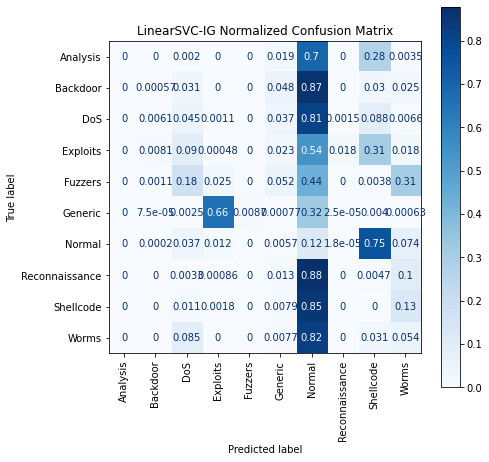

In [24]:
conf_mat_ig, class_rep_ig, rep_dict_ig, acc_ig = gen_metrics(y_train, y_pred_ig)
print(class_rep_ig)
plt_norm_confmat(lin_svc_model_3, train_std_ig, y_train, 'LinearSVC-IG Normalized Confusion Matrix', 
                 fname='lin_svc_3_ig_conf_mat', labels=class_names)
plt.show()

In [41]:
joblib.dump(conf_mat_ig, './data/conf_mat_ig.pkl')
joblib.dump(rep_dict_ig, './data/rep_dict_ig.pkl')

['./data/rep_dict_ig.pkl']

Let's try the same parameters on the other feature subsets.

ANOVA feature subset...

In [14]:
lin_svc_model_3_anova = LinearSVC(C=3, loss='squared_hinge', dual=False, class_weight='balanced')
lin_svc_model_3_anova.fit(train_std_anova, y_train)
lin_svc_model_3_anova.n_iter_

33

In [16]:
joblib.dump(lin_svc_model_3_anova, './data/lin_svc_model_3_anova.pkl')
#lin_svc_model_3_anova = joblib.load('./data/lin_svc_model_3_anova.pkl')

['./data/lin_svc_model_3_anova.pkl']

In [15]:
lin_svc_model_3_anova.score(train_std_ig, y_train)

0.04060088627303369

In [20]:
y_pred_anova = cross_val_predict(lin_svc_model_3_anova, train_std_anova, y_train, cv=5, n_jobs=-1)  # save the test set for final models
y_pred_anova

array([8, 4, 3, ..., 2, 5, 5])

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2000
           1       0.08      0.05      0.06      1746
           2       0.30      0.54      0.39     12264
           3       0.65      0.40      0.50     33393
           4       0.49      0.61      0.54     18184
           5       0.95      0.96      0.96     40000
           6       0.97      0.73      0.83     56000
           7       0.23      0.09      0.13     10491
           8       0.05      0.52      0.09      1133
           9       0.01      0.51      0.01       130

    accuracy                           0.64    175341
   macro avg       0.37      0.44      0.35    175341
weighted avg       0.74      0.64      0.67    175341



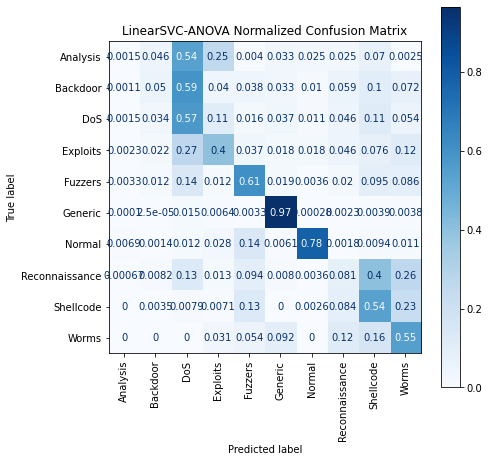

In [21]:
conf_mat_anova, class_rep_anova, rep_dict_anova, acc_anova = gen_metrics(y_train, y_pred_anova)
print(class_rep_anova)
plt_norm_confmat(lin_svc_model_3_anova, train_std_anova, y_train, 'LinearSVC-ANOVA Normalized Confusion Matrix', 
                 fname='lin_svc_3_anova_conf_mat', labels=class_names)
plt.show()

In [42]:
joblib.dump(conf_mat_anova, './data/conf_mat_anova.pkl')
joblib.dump(rep_dict_anova, './data/rep_dict_anova.pkl')

['./data/rep_dict_anova.pkl']

Variance Threshold feature subset

In [17]:
lin_svc_model_3_vt = LinearSVC(C=3, loss='squared_hinge', dual=False, class_weight='balanced')
lin_svc_model_3_vt.fit(train_std_vt, y_train)
lin_svc_model_3_vt.n_iter_

325

In [19]:
joblib.dump(lin_svc_model_3_vt, './data/lin_svc_model_3_vt.pkl')
#lin_svc_model_3_vt = joblib.load('./data/lin_svc_model_3_vt.pkl')

['./data/lin_svc_model_3_vt.pkl']

In [18]:
lin_svc_model_3_vt.score(train_std_vt, y_train)

0.6226267672706327

In [27]:
y_pred_vt = cross_val_predict(lin_svc_model_3_vt, train_std_vt, y_train, cv=5, n_jobs=-1)  # save the test set for final models
y_pred_vt

array([7, 3, 3, ..., 5, 5, 5])

              precision    recall  f1-score   support

           0       0.03      0.05      0.04      2000
           1       0.05      0.08      0.06      1746
           2       0.29      0.17      0.21     12264
           3       0.75      0.37      0.49     33393
           4       0.47      0.55      0.51     18184
           5       0.59      0.98      0.74     40000
           6       0.97      0.75      0.84     56000
           7       0.46      0.26      0.33     10491
           8       0.06      0.06      0.06      1133
           9       0.01      0.52      0.02       130

    accuracy                           0.62    175341
   macro avg       0.37      0.38      0.33    175341
weighted avg       0.69      0.62      0.62    175341



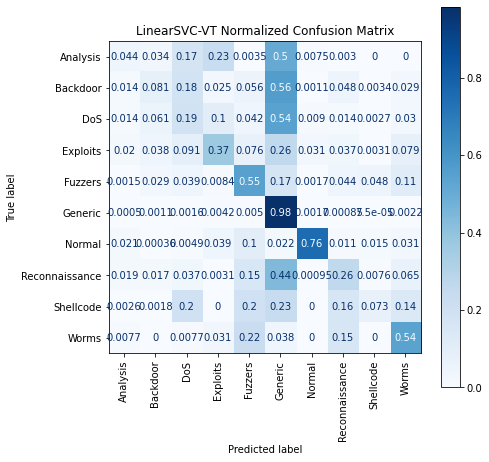

In [28]:
conf_mat_vt, class_rep_vt, rep_dict_vt, acc_vt = gen_metrics(y_train, y_pred_vt)
print(class_rep_vt)
plt_norm_confmat(lin_svc_model_3_vt, train_std_vt, y_train, 'LinearSVC-VT Normalized Confusion Matrix', 
                 fname='lin_svc_3_vt_conf_mat', labels=class_names)
plt.show()

In [43]:
joblib.dump(conf_mat_vt, './data/conf_mat_vt.pkl')
joblib.dump(rep_dict_vt, './data/rep_dict_vt.pkl')

['./data/rep_dict_vt.pkl']

Median Absolute Deviation (MAD) feature subset...

In [20]:
lin_svc_model_3_mad = LinearSVC(C=3, loss='squared_hinge', dual=False, class_weight='balanced')
lin_svc_model_3_mad.fit(train_std_mad, y_train)
lin_svc_model_3_mad.n_iter_

321

In [22]:
joblib.dump(lin_svc_model_3_mad, './data/lin_svc_model_3_mad.pkl')
#lin_svc_model_3_mad = joblib.load('./data/lin_svc_model_3_mad.pkl')

['./data/lin_svc_model_3_mad.pkl']

In [21]:
lin_svc_model_3_mad.score(train_std_mad, y_train)

0.681118506225013

In [31]:
y_pred_mad = cross_val_predict(lin_svc_model_3_mad, train_std_mad, y_train, cv=5, n_jobs=-1)  # save the test set for final models
y_pred_mad

array([8, 6, 3, ..., 2, 5, 5])

              precision    recall  f1-score   support

           0       0.06      0.03      0.04      2000
           1       0.06      0.06      0.06      1746
           2       0.31      0.49      0.38     12264
           3       0.71      0.40      0.51     33393
           4       0.52      0.62      0.56     18184
           5       0.91      0.97      0.94     40000
           6       0.99      0.75      0.85     56000
           7       0.38      0.61      0.47     10491
           8       0.14      0.51      0.22      1133
           9       0.01      0.62      0.02       130

    accuracy                           0.68    175341
   macro avg       0.41      0.51      0.41    175341
weighted avg       0.76      0.68      0.70    175341



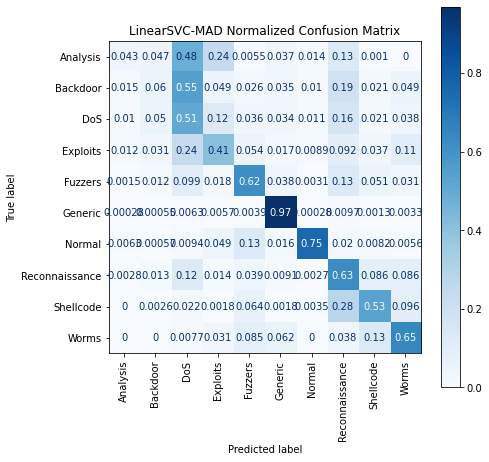

In [32]:
conf_mat_mad, class_rep_mad, rep_dict_mad, acc_mad = gen_metrics(y_train, y_pred_mad)
print(class_rep_mad)
plt_norm_confmat(lin_svc_model_3_mad, train_std_mad, y_train, 'LinearSVC-MAD Normalized Confusion Matrix', 
                 fname='lin_svc_3_mad_conf_mat', labels=class_names)
plt.show()

In [45]:
joblib.dump(conf_mat_mad, './data/conf_mat_mad.pkl')
joblib.dump(rep_dict_mad, './data/rep_dict_mad.pkl')

['./data/rep_dict_mad.pkl']

Correlated feature subset...

In [23]:
lin_svc_model_3_corr = LinearSVC(C=3, loss='squared_hinge', max_iter=15000, dual=False, class_weight='balanced')
lin_svc_model_3_corr.fit(train_std_corr, y_train)
lin_svc_model_3_corr.n_iter_

2723

In [25]:
joblib.dump(lin_svc_model_3_corr, './data/lin_svc_model_3_corr.pkl')
#lin_svc_model_3_corr = joblib.load('./data/lin_svc_model_3_corr.pkl')

['./data/lin_svc_model_3_corr.pkl']

In [24]:
lin_svc_model_3_corr.score(train_std_corr, y_train)

0.616301948774103

In [36]:
y_pred_corr = cross_val_predict(lin_svc_model_3_corr, train_std_corr, y_train, cv=5, n_jobs=-1)  # save the test set for final models
y_pred_corr

array([8, 3, 3, ..., 2, 5, 5])

              precision    recall  f1-score   support

           0       0.23      0.12      0.15      2000
           1       0.04      0.03      0.03      1746
           2       0.31      0.50      0.38     12264
           3       0.55      0.31      0.40     33393
           4       0.45      0.54      0.49     18184
           5       0.95      0.96      0.96     40000
           6       0.91      0.69      0.78     56000
           7       0.29      0.14      0.19     10491
           8       0.05      0.77      0.09      1133
           9       0.01      0.64      0.03       130

    accuracy                           0.60    175341
   macro avg       0.38      0.47      0.35    175341
weighted avg       0.70      0.60      0.64    175341



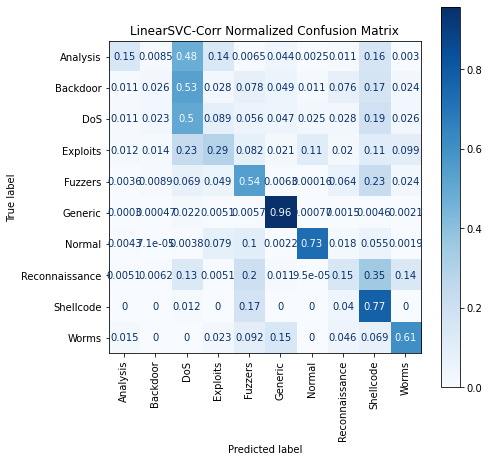

In [38]:
conf_mat_corr, class_rep_corr, rep_dict_corr, acc_corr = gen_metrics(y_train, y_pred_corr)
print(class_rep_corr)
plt_norm_confmat(lin_svc_model_3_corr, train_std_corr, y_train, 'LinearSVC-Corr Normalized Confusion Matrix', 
                 fname='lin_svc_3_corr_conf_mat', labels=class_names)
plt.show()

In [44]:
joblib.dump(conf_mat_corr, './data/conf_mat_corr.pkl')
joblib.dump(rep_dict_corr, './data/rep_dict_corr.pkl')

['./data/rep_dict_corr.pkl']

Recursive Feature Elimination (RFE) subset...

In [40]:
lin_svc_model_3_rfe = LinearSVC(C=3, loss='squared_hinge', max_iter=15000, dual=False, class_weight='balanced')
lin_svc_model_3_rfe.fit(train_std_rfe, y_train)
lin_svc_model_3_rfe.n_iter_

c:\users\phil\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


15000

Using this set of 165 features, the model fails to converge after 15,000 iterations and ~5 hours.  
Presumably using this many features makes the data set too large for a linear kernel SVM.

In [ ]:
lin_svc_model_3_rfe.score(train_std_rfe, y_train)

In [ ]:
y_pred_rfe = cross_val_predict(lin_svc_model_3_rfe, train_std_rfe, y_train, cv=5, n_jobs=-1)  # save the test set for final models
y_pred_rfe

In [ ]:
conf_mat_rfe, class_rep_rfe rep_dict_rfe, acc_rfe = gen_metrics(y_train, y_pred_rfe)
print(class_rep_rfe)
plt_norm_confmat(lin_svc_model_3_rfe, train_std_rfe, y_train, 'LinearSVC-RFE Normalized Confusion Matrix', 
                 fname='lin_svc_3_rfe_conf_mat', labels=class_names)
plt.show()

#### Let's make some plots for comparison

In [16]:
rep_dict_ig = joblib.load('./data/rep_dict_ig.pkl')
rep_dict_anova = joblib.load('./data/rep_dict_anova.pkl')
rep_dict_vt = joblib.load('./data/rep_dict_vt.pkl')
rep_dict_mad = joblib.load('./data/rep_dict_mad.pkl')
rep_dict_corr = joblib.load('./data/rep_dict_corr.pkl')

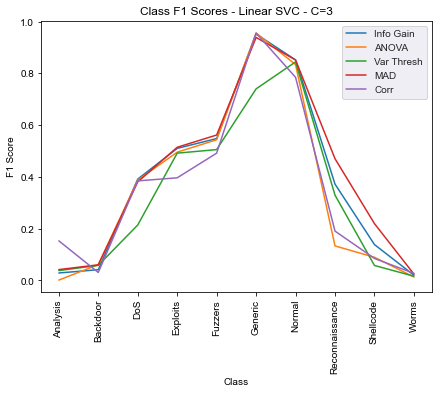

In [16]:
lin_svc_reports = [rep_dict_ig, rep_dict_anova, rep_dict_vt, rep_dict_mad, rep_dict_corr]#, rep_dict_rfe]
lin_svc_lgnds = ['Info Gain', 'ANOVA', 'Var Thresh', 'MAD', 'Corr']#, 'RFE']
labels = ['0', '1', '2', '3','4', '5', '6', '7', '8', '9']
fig, ax = plt.subplots(figsize=(7, 5))
sns.set_style('darkgrid')

for report, lgnd in zip(lin_svc_reports, lin_svc_lgnds):
    f1_scores = []
    for lab in labels:
        f1_scores.append(report[lab]['f1-score'])
    sns.lineplot(x=label_encoder.classes_, y=f1_scores, label=lgnd)
plt.xlabel('Class')
plt.xticks(rotation=90, horizontalalignment='center')
plt.ylabel('F1 Score')
plt.title('Class F1 Scores - Linear SVC - C=3')
plt.legend()
plt.savefig('./images/class_f1s_lin_svc_3.png', dpi=300, bbox_inches='tight')
plt.show()

In [17]:
# let's grab come metrics so we can plot them togther
lin_svc_f1_acc = [('Accuracy', 'Info Gain', rep_dict_ig['accuracy']),
                  ('Accuracy', 'ANOVA', rep_dict_anova['accuracy']),
                  ('Accuracy', 'Var Thresh', rep_dict_vt['accuracy']),
                  ('Accuracy', 'MAD', rep_dict_mad['accuracy']),
                  ('Accuracy', 'Corr', rep_dict_corr['accuracy']),
                  #('Accuracy', 'RFE', rep_dict_rfe['accuracy']),
                  ('Weighted Avg F1', 'Info Gain', rep_dict_ig['weighted avg']['f1-score']),
                  ('Weighted Avg F1', 'ANOVA', rep_dict_anova['weighted avg']['f1-score']),
                  ('Weighted Avg F1', 'Var Thresh', rep_dict_vt['weighted avg']['f1-score']),
                  ('Weighted Avg F1', 'MAD', rep_dict_mad['weighted avg']['f1-score']),
                  ('Weighted Avg F1', 'Corr', rep_dict_corr['weighted avg']['f1-score'])]#,
                  #('Weighted Avg F1', 'RFE', rep_dict_rfe['weighted avg']['f1-score'])]
lin_svc_metric_df = pd.DataFrame(lin_svc_f1_acc, columns=['Metric', 'Feature Subset', 'Score'])

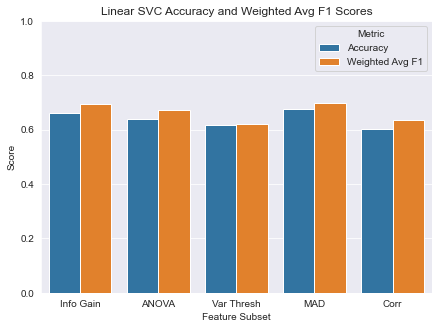

In [18]:
plt.figure(figsize=(7, 5))
sns.set_style('darkgrid')
lin_svc_metric_chart = sns.barplot(x='Feature Subset', y='Score', hue='Metric', data=lin_svc_metric_df)
lin_svc_metric_chart.set_title('Linear SVC Accuracy and Weighted Avg F1 Scores')
plt.ylim(ymax=1.0)
#plt.legend(loc='lower right')
plt.savefig('./images/feat_subset_acc_f1_lin_svc.png', dpi=300, bbox_inches='tight')
plt.show()

Let's consider testing the most important features identified by the RandomForest classifier.  
1e-3 seems like a good cut-off, which will give us the top 50 features.

In [14]:
rfb3_sorted_importances = joblib.load('./data/rfb3_sorted_feature_importances.pkl')

In [15]:
top_feats = [x[0] for x in rfb3_sorted_importances if x[1] > 1e-3]

In [16]:
train_std_RF = training_data_std[top_feats].copy()
test_std_RF = testing_data_std[top_feats].copy()

In [17]:
lin_svc_model_3_RF = LinearSVC(C=3, loss='squared_hinge', max_iter=15000, dual=False, class_weight='balanced')
lin_svc_model_3_RF.fit(train_std_RF, y_train)
lin_svc_model_3_RF.n_iter_

7960

In [18]:
joblib.dump(lin_svc_model_3_RF, './data/lin_svc_model_3_RF.pkl')
#lin_svc_model_3_RF = joblib.load('./data/lin_svc_model_3_RF.pkl')

['./data/lin_svc_model_3_RF.pkl']

In [19]:
#y_pred_RF = lin_svc_model_3_RF.predict(test_std_RF)
y_pred_RF = cross_val_predict(lin_svc_model_3_RF, train_std_RF, y_train, cv=5, n_jobs=-1)  # save the test set for final models

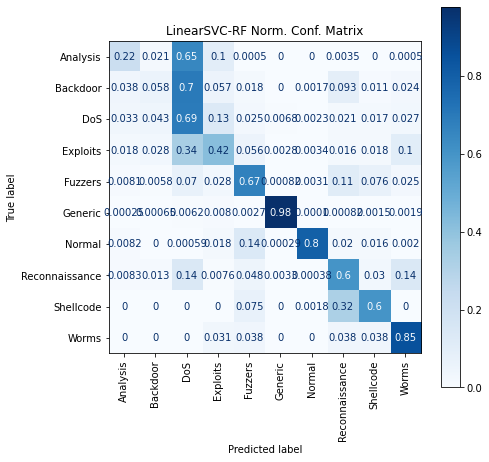

              precision    recall  f1-score   support

           0       0.18      0.20      0.19      2000
           1       0.05      0.06      0.05      1746
           2       0.33      0.68      0.45     12264
           3       0.74      0.42      0.53     33393
           4       0.52      0.67      0.58     18184
           5       0.99      0.98      0.99     40000
           6       0.99      0.76      0.86     56000
           7       0.58      0.60      0.59     10491
           8       0.15      0.59      0.24      1133
           9       0.02      0.82      0.03       130

    accuracy                           0.71    175341
   macro avg       0.46      0.58      0.45    175341
weighted avg       0.80      0.71      0.73    175341

0.7061155120593586


In [20]:
# make sure to use y_train, not y_test since we're using cross_val_predict, not predicting on the test set
con_mat_RF = confusion_matrix(y_train, y_pred_RF)
#print(con_mat_RF)
plt_norm_confmat(lin_svc_model_3_RF, train_std_RF, y_train, 'LinearSVC-RF Norm. Conf. Matrix', 
                 fname='lin_svc_3_RF_conf_mat', labels=class_names)
plt.show()
class_rep_RF = classification_report(y_train, y_pred_RF)
rep_dict_RF = classification_report(y_train, y_pred_RF, output_dict=True)
print(class_rep_RF)
acc_RF = accuracy_score(y_train, y_pred_RF)
print(acc_RF)

In [21]:
joblib.dump(con_mat_RF, './data/con_mat_lin_svc_3_RF.pkl')

['./data/con_mat_lin_svc_3_RF.pkl']

In [22]:
joblib.dump(rep_dict_RF, './data/lin_svc_3_RF_class_rep.pkl')

['./data/lin_svc_3_RF_class_rep.pkl']

## Model evaluation

In [17]:
svc_ig_final = joblib.load('./data/lin_svc_model_3.pkl')
svc_anova_final = joblib.load('./data/lin_svc_model_3_anova.pkl')
svc_vt_final = joblib.load('./data/lin_svc_model_3_vt.pkl')
svc_mad_final = joblib.load('./data/lin_svc_model_3_mad.pkl')
svc_corr_final = joblib.load('./data/lin_svc_model_3_corr.pkl')
svc_RF_final = joblib.load('./data/lin_svc_model_3_RF.pkl')

### Info Gain

In [18]:
y_pred_final_svc_ig = svc_ig_final.predict(test_std_ig)

In [19]:
final_conf_mat_svc_ig, final_class_rep_svc_ig, final_rep_dict_svc_ig, final_acc_svc_ig = gen_metrics(y_test, y_pred_final_svc_ig)
print(final_class_rep_svc_ig)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       677
           1       0.03      0.07      0.04       583
           2       0.30      0.48      0.37      4089
           3       0.47      0.48      0.47     11132
           4       0.31      0.55      0.40      6062
           5       0.86      0.84      0.85     18871
           6       0.91      0.50      0.64     37000
           7       0.28      0.73      0.41      3496
           8       0.00      0.00      0.00       378
           9       0.01      0.66      0.01        44

    accuracy                           0.58     82332
   macro avg       0.32      0.43      0.32     82332
weighted avg       0.72      0.58      0.61     82332



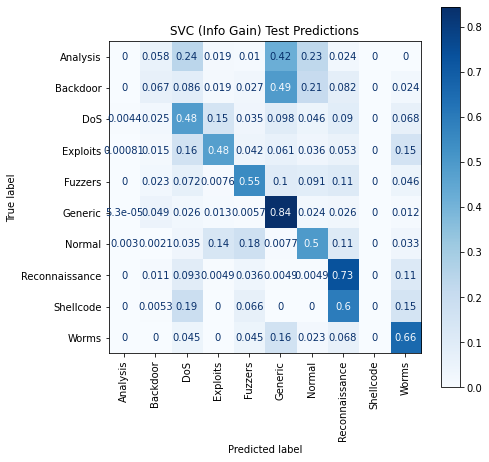

In [20]:
plt_norm_confmat(svc_ig_final, test_std_ig, y_test, 'SVC (Info Gain) Test Predictions', 
                 fname='final_svc_ig_conf_mat', labels=class_names)

In [21]:
joblib.dump(final_rep_dict_svc_ig, 'final_rep_dict_svc_ig.pkl')

['final_rep_dict_svc_ig.pkl']

In [22]:
joblib.dump(final_conf_mat_svc_ig, 'final_conf_mat_svc_ig.pkl')

['final_conf_mat_svc_ig.pkl']

### ANOVA features

In [23]:
y_pred_final_svc_anova = svc_anova_final.predict(test_std_anova)

In [24]:
final_conf_mat_svc_anova, final_class_rep_svc_anova, final_rep_dict_svc_anova, final_acc_svc_anova = gen_metrics(y_test, y_pred_final_svc_anova)
print(final_class_rep_svc_anova)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       677
           1       0.03      0.08      0.04       583
           2       0.24      0.47      0.32      4089
           3       0.53      0.48      0.51     11132
           4       0.33      0.48      0.39      6062
           5       0.84      0.81      0.82     18871
           6       0.91      0.54      0.68     37000
           7       0.24      0.52      0.33      3496
           8       0.00      0.00      0.00       378
           9       0.00      0.57      0.01        44

    accuracy                           0.58     82332
   macro avg       0.31      0.39      0.31     82332
weighted avg       0.72      0.58      0.62     82332



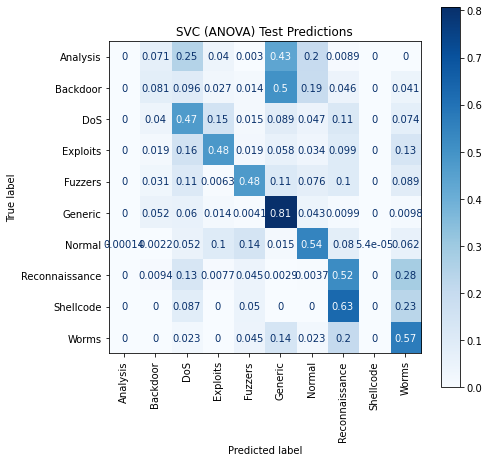

In [25]:
plt_norm_confmat(svc_anova_final, test_std_anova, y_test, 'SVC (ANOVA) Test Predictions', 
                 fname='final_svc_anova_conf_mat', labels=class_names)

In [26]:
joblib.dump(final_rep_dict_svc_anova, 'final_rep_dict_svc_anova.pkl')

['final_rep_dict_svc_anova.pkl']

In [27]:
joblib.dump(final_conf_mat_svc_anova, 'final_conf_mat_svc_anova.pkl')

['final_conf_mat_svc_anova.pkl']

### Variance Threshold features

In [28]:
y_pred_final_svc_vt = svc_vt_final.predict(test_std_vt)

In [29]:
final_conf_mat_svc_vt, final_class_rep_svc_vt, final_rep_dict_svc_vt, final_acc_svc_vt = gen_metrics(y_test, y_pred_final_svc_vt)
print(final_class_rep_svc_vt)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       677
           1       0.04      0.05      0.04       583
           2       0.25      0.17      0.20      4089
           3       0.50      0.45      0.47     11132
           4       0.22      0.52      0.31      6062
           5       0.66      0.96      0.78     18871
           6       0.96      0.53      0.68     37000
           7       0.32      0.31      0.31      3496
           8       0.00      0.00      0.00       378
           9       0.00      0.34      0.01        44

    accuracy                           0.58     82332
   macro avg       0.30      0.33      0.28     82332
weighted avg       0.69      0.58      0.60     82332



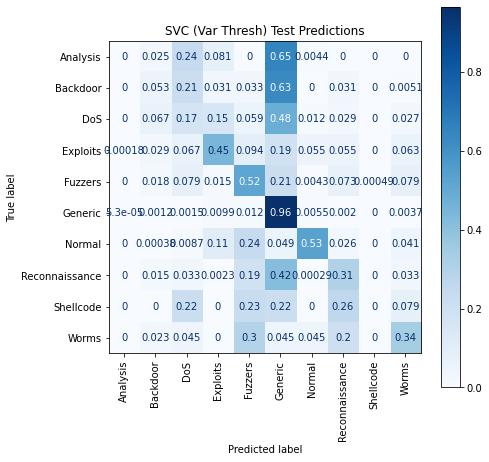

In [30]:
plt_norm_confmat(svc_vt_final, test_std_vt, y_test, 'SVC (Var Thresh) Test Predictions', 
                 fname='final_svc_vt_conf_mat', labels=class_names)

In [31]:
joblib.dump(final_rep_dict_svc_vt, 'final_rep_dict_svc_vt.pkl')

['final_rep_dict_svc_vt.pkl']

In [32]:
joblib.dump(final_conf_mat_svc_vt, 'final_conf_mat_svc_vt.pkl')

['final_conf_mat_svc_vt.pkl']

### Median Absolute Deviation features

In [33]:
y_pred_final_svc_mad = svc_mad_final.predict(test_std_mad)

In [34]:
final_conf_mat_svc_mad, final_class_rep_svc_mad, final_rep_dict_svc_mad, final_acc_svc_mad = gen_metrics(y_test, y_pred_final_svc_mad)
print(final_class_rep_svc_mad)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       677
           1       0.01      0.02      0.02       583
           2       0.26      0.49      0.34      4089
           3       0.46      0.49      0.47     11132
           4       0.30      0.59      0.40      6062
           5       0.85      0.80      0.83     18871
           6       0.88      0.49      0.63     37000
           7       0.28      0.82      0.42      3496
           8       0.00      0.00      0.00       378
           9       0.02      0.41      0.03        44

    accuracy                           0.57     82332
   macro avg       0.31      0.41      0.31     82332
weighted avg       0.70      0.57      0.60     82332



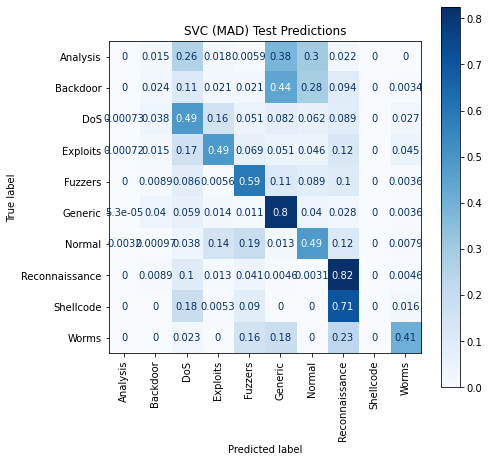

In [35]:
plt_norm_confmat(svc_mad_final, test_std_mad, y_test, 'SVC (MAD) Test Predictions', 
                 fname='final_svc_mad_conf_mat', labels=class_names)

In [36]:
joblib.dump(final_rep_dict_svc_mad, 'final_rep_dict_svc_mad.pkl')

['final_rep_dict_svc_mad.pkl']

In [37]:
joblib.dump(final_conf_mat_svc_mad, 'final_conf_mat_svc_mad.pkl')

['final_conf_mat_svc_mad.pkl']

### Correlation features

In [38]:
y_pred_final_svc_corr = svc_corr_final.predict(test_std_corr)

In [39]:
final_conf_mat_svc_corr, final_class_rep_svc_corr, final_rep_dict_svc_corr, final_acc_svc_corr = gen_metrics(y_test, y_pred_final_svc_corr)
print(final_class_rep_svc_corr)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       677
           1       0.02      0.02      0.02       583
           2       0.19      0.52      0.28      4089
           3       0.31      0.30      0.30     11132
           4       0.21      0.64      0.32      6062
           5       0.85      0.81      0.83     18871
           6       0.85      0.45      0.59     37000
           7       0.17      0.16      0.16      3496
           8       0.00      0.00      0.00       378
           9       0.00      0.00      0.00        44

    accuracy                           0.51     82332
   macro avg       0.26      0.29      0.25     82332
weighted avg       0.65      0.51      0.54     82332



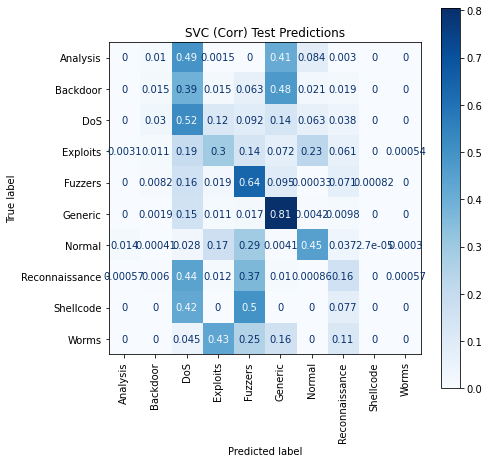

In [40]:
plt_norm_confmat(svc_corr_final, test_std_corr, y_test, 'SVC (Corr) Test Predictions', 
                 fname='final_svc_corr_conf_mat', labels=class_names)

In [41]:
joblib.dump(final_rep_dict_svc_corr, 'final_rep_dict_svc_corr.pkl')

['final_rep_dict_svc_corr.pkl']

In [42]:
joblib.dump(final_conf_mat_svc_corr, 'final_conf_mat_svc_corr.pkl')

['final_conf_mat_svc_corr.pkl']

### Random Forest optimum features

In [43]:
y_pred_final_svc_RF = svc_RF_final.predict(test_std_RF)

In [44]:
final_conf_mat_svc_RF, final_class_rep_svc_RF, final_rep_dict_svc_RF, final_acc_svc_RF = gen_metrics(y_test, y_pred_final_svc_RF)
print(final_class_rep_svc_RF)

              precision    recall  f1-score   support

           0       0.10      0.59      0.17       677
           1       0.04      0.04      0.04       583
           2       0.43      0.50      0.46      4089
           3       0.62      0.52      0.56     11132
           4       0.26      0.64      0.37      6062
           5       0.99      0.96      0.98     18871
           6       0.99      0.58      0.73     37000
           7       0.35      0.83      0.49      3496
           8       0.00      0.00      0.00       378
           9       0.03      0.32      0.06        44

    accuracy                           0.66     82332
   macro avg       0.38      0.50      0.39     82332
weighted avg       0.81      0.66      0.70     82332



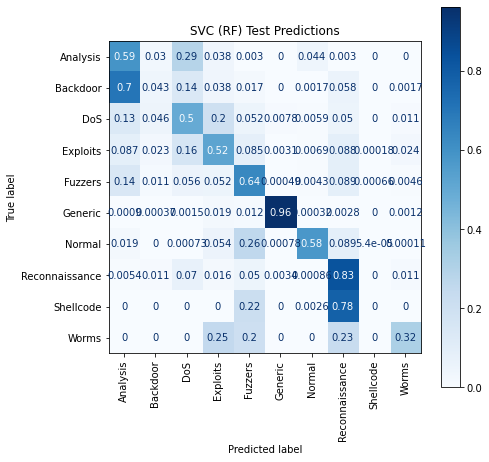

In [45]:
plt_norm_confmat(svc_RF_final, test_std_RF, y_test, 'SVC (RF) Test Predictions', 
                 fname='final_svc_RF_conf_mat', labels=class_names)

In [46]:
joblib.dump(final_rep_dict_svc_RF, 'final_rep_dict_svc_RF.pkl')

['final_rep_dict_svc_RF.pkl']

In [47]:
joblib.dump(final_conf_mat_svc_RF, 'final_conf_mat_svc_RF.pkl')

['final_conf_mat_svc_RF.pkl']